In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import os
import numpy as np
import pandas as pd
import graphviz
from IPython.display import Image
from difflib import SequenceMatcher
pd.options.mode.chained_assignment = None

DECALAGE = False

In [ ]:
filenames = next(os.walk("./"), (None, None, []))[2]
anion_file_name = None
cation_file_name = None
if len(filenames) == 0:
  raise BaseException("No files were imported.")
for f in filenames:
  if "Anionic-Cationic" in f:
    anion_file_name = f
    cation_file_name = f
    break
  elif "Anionic" in f:
    anion_file_name = f
  elif "Cationic" in f:
    cation_file_name = f

if anion_file_name is None or cation_file_name is None:
    raise BaseException("Do the name of the files follow the following convention, such that it should contain 'Anionic-Cationic', 'Anionic' or 'Cationic'")

if anion_file_name == cation_file_name:
  a = int(input("Do you wish to run the experiments on both the cations and anions at the same time ? (Enter 1 to continue) "))
  if a != 1:
    anion_file_name = None
    cation_file_name = None
    raise BaseException("Automatically getting file names did not work.\nThere appears to be a file that contains 'Anionic-Cationic' in its name.")
else:
  a = int(input("Do you wish to use the following file with anions ? "+ anion_file_name+ " (Enter 1 to continue) "))
  b = int(input("Do you wish to use the following file with cations ? "+ cation_file_name+ " (Enter 1 to continue) "))
  if a != 1 or b != 1:
    raise BaseException("Automatically getting file names did not work.\n There seems to be multiple filenames that contain 'Anionic' or 'Cationic'")

Vous souhaitez utiliser le fichier suivant pour les anions ? Anionic_16 membranes_ VF.csv (Entrez 1 pour continuer) 1
Vous souhaitez utiliser le fichier suivant pour les cations ? Cationic_16 membranes_VF.csv (Entrez 1 pour continuer) 1


# Code

In [ ]:
### DATALOADER
# complete_file_with_useless_peptides = DECALAGE
# decalage = np.array([36, 22])
decalage = np.array([34, 22])
decalage_full = 56
is_equal = (anion_file_name == cation_file_name)
anion_file_name = "./" + anion_file_name
cation_file_name = "./" + cation_file_name
def load_data(boolean):
    if boolean:
      df = pd.read_csv(cation_file_name, sep=";")
    else:
      df = pd.read_csv(anion_file_name, sep=";")

    if DECALAGE:
      df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]

    l = ['R1 A-', 'R2 A-', 'R3 A-', 'R1 C+', 'R2 C+', 'R3 C+']
    y = df[l]
    y.rename(columns={'R1 A-': 'R1_A', 'R2 A-': 'R2_A',
                      'R3 A-': 'R3_A', 'R1 C+': 'R1_C',
                      'R2 C+': 'R2_C', 'R3 C+': 'R3_C'},
             inplace=True)
    l = l + ['membrane', 'Peptides', 'bend_percent', 'turn_percent']
    df = df.drop(columns=l)
    return df, y

def load_data_mean(boolean):
    """
    Returns the data. We take the mean of the response variable.
    :param boolean: True if we want positive data, False otherwise. 
    :return:
    """
    df, y = load_data(boolean)
    if boolean:
        y_pos = y[['R1_C', 'R2_C', 'R2_C']].mean(axis=1)
        return df, y_pos
    else:
        y_neg = y[['R1_A', 'R2_A', 'R3_A']].mean(axis=1)
        return df, y_neg

def get_peptides_names(boolean):
      if boolean:
        df = pd.read_csv(cation_file_name, sep=";")
      else:
        df = pd.read_csv(anion_file_name, sep=";")

      if DECALAGE:
        df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]
      return (df['membrane'] + ' + ' + df['Peptides'])

def get_features(X, y, threshold):
  regressor = RandomForestRegressor(random_state=1, n_estimators=1000)
  regressor.fit(X, y)
  feat_importance = pd.DataFrame(regressor.feature_importances_.T, index=X_selected.columns).sort_values(by=0,
                                                                                                        ascending=False)
  new_indexs_pos = feat_importance[feat_importance[0] > threshold].index
  return new_indexs_pos

def get_decisions(X, y, depth):
    regressor = DecisionTreeRegressor(random_state=1, max_depth=depth, criterion='squared_error')
    scoring = {"r2": 'r2', 'rmse':'neg_root_mean_squared_error'}
    parameters = {'min_samples_split':[2,3,4,5,6],
                  'min_samples_leaf':[2,3,4,5,6]}
    clf = GridSearchCV(regressor, parameters, scoring=scoring, refit="r2")
    clf.fit(X, y)

    # mean_test_score = clf.cv_results_['mean_test_r2']
    # std_test_score = clf.cv_results_['std_test_r2']
    # mean_test_rmse = clf.cv_results_['mean_test_rmse']
    # std_test_rmse = clf.cv_results_['std_test_rmse']

    clf1 = DecisionTreeRegressor(random_state=1,
                                 criterion='squared_error',
                                 max_depth=depth,
                                 min_samples_split=clf.best_params_['min_samples_split'],
                                 min_samples_leaf=clf.best_params_['min_samples_leaf'])
    clf1.fit(X, y)

    n_leaves = clf1.tree_.n_leaves
    indice = np.argmax(clf.cv_results_['mean_test_r2'])
    mean_test = clf.cv_results_['mean_test_r2'][indice]
    std_test = clf.cv_results_['std_test_r2'][indice]
    best_test_rmse = -clf.cv_results_['mean_test_rmse'][indice]
    best_std_rmse = clf.cv_results_['std_test_rmse'][indice]

    mean_std = (f"{mean_test:.3f}" + u"\u00B1" + f"{std_test:.3f} \n {best_test_rmse:.3f}" + u"\u00B1" + f"{best_std_rmse:.3f}")
    # print("Le r^2 de l'arbre durant la validation croisée est de :", mean_std)

    r2_score = clf1.score(X, y)
    # print("Le r^2 de l'arbre est : ", r2_score)
    return r2_score, n_leaves, mean_test, mean_std, clf1

def print_tree(clf, feature_name, file_name):
    dot_data = tree.export_graphviz(clf, out_file=None,
                            feature_names=feature_name,
                            filled=True, rounded=True,
                            special_characters=True, rotate=True, leaves_parallel=True)

    graph = graphviz.Source(dot_data)
    graph.dpi = 500
    graph.size = "30,30!"
    graph.render(file_name, format='jpg')
    os.remove(file_name)

# Avec 16 membranes

In [ ]:
membrane = ['Contact angle', 'hydrophilic pores',
            'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
           'GRAVY', 'm/z_at_pH7.0',
            'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
            'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

DECALAGE = False

depths = [2, 3, 4, 5, 6, 7, None]
r2_results = []
leaves_results = []
mean_std_results = []
mean_results = []

for anion_cation in [True, False]:
    for threshold in [0.02, 0.05]:
        r2s = []
        ns = []
        mean_stds = []
        means = []
        for depth in depths:
            X, y = load_data_mean(anion_cation)
            X_selected = X[features]
            regressor = RandomForestRegressor(random_state=1, n_estimators=1000)
            regressor.fit(X_selected, y)
            feat_importance = pd.DataFrame(regressor.feature_importances_.T, index=X_selected.columns).sort_values(by=0,
                                                                                                                   ascending=False)
            new_indexs_pos = feat_importance[feat_importance[0] > threshold].index
            r2_score, n_leaves, mean_test, mean_std, clf = get_decisions(X_selected[new_indexs_pos], y, depth)

            if depth in [4,5]:
              print_tree(clf, new_indexs_pos, f"decision_tree_16membranes_depth={depth}_threshold={threshold}_"+("cation" if anion_cation else "anion"))

            r2s.append(r2_score)
            ns.append(n_leaves)
            mean_stds.append(mean_std)
            means.append(mean_test)

        r2_results.append(r2s)
        leaves_results.append(ns)
        mean_std_results.append(mean_stds)
        mean_results.append(means)

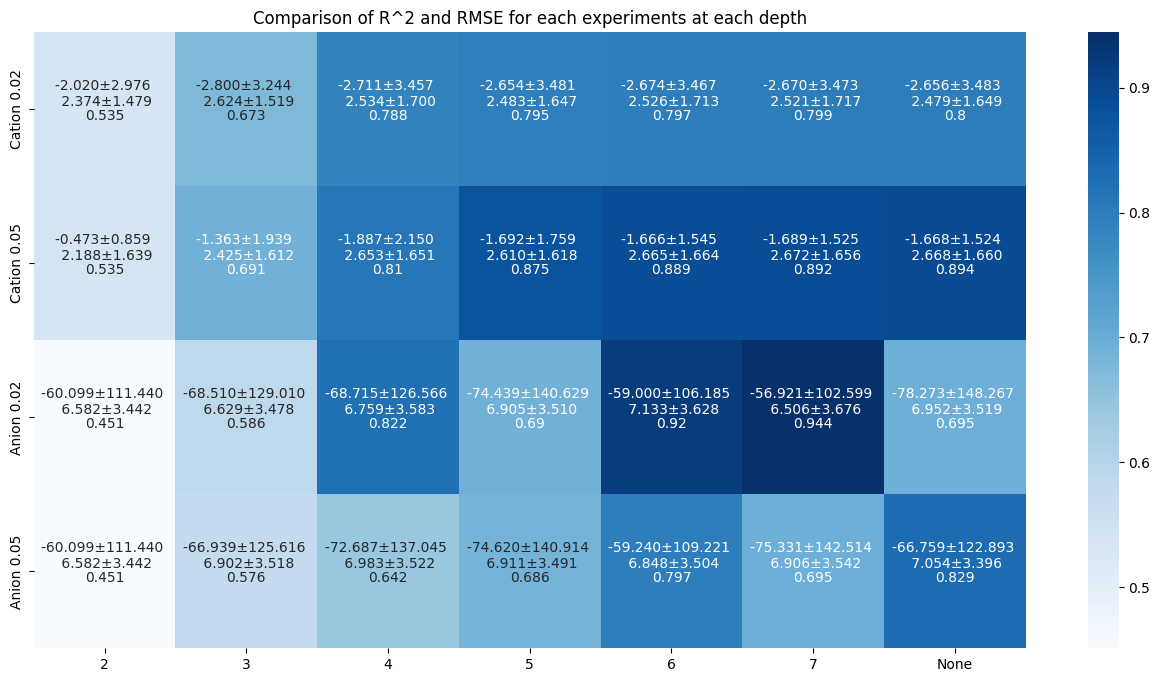

In [ ]:
val_df = pd.DataFrame(r2_results, index=['Cation 0.02', 'Cation 0.05', 'Anion 0.02', 'Anion 0.05'], columns=[2, 3, 4, 5, 6, 7, "None"])
plt.figure(figsize = (16,8))
plt.title("Comparison of R^2 and RMSE for each experiments at each depth")
sn.heatmap(val_df, annot=False, cmap='Blues')
sn.heatmap(val_df, annot=mean_std_results, annot_kws={'va':'bottom'}, cbar=False, fmt='', cmap='Blues')
sn.heatmap(val_df, annot=r2_results, annot_kws={'va':'top'}, fmt='.3g', cbar=False, cmap='Blues')
plt.savefig("./exp_results_heatmaps_16_membranes.jpg")

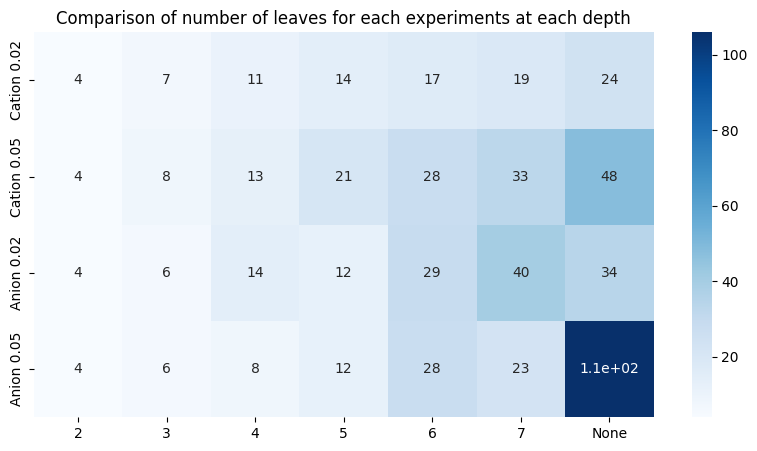

In [ ]:
plt.figure(figsize = (10,5))
plt.title("Comparison of number of leaves for each experiments at each depth")
leaves_df = pd.DataFrame(leaves_results, index=['Cation 0.02', 'Cation 0.05', 'Anion 0.02', 'Anion 0.05'], columns=[2, 3, 4, 5, 6, 7, "None"])
sn.heatmap(leaves_df, annot=leaves_df, cmap='Blues')
plt.savefig("./depth_heatmaps_16_membranes.jpg")

# Avec 14 membranes

In [ ]:
membrane = ['Contact angle', 'hydrophilic pores',
            'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

peptide = ['mol_weight', 'isoelectric_point',
           'GRAVY', 'm/z_at_pH7.0',
            'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
            'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

features = membrane + peptide

DECALAGE = True

depths = [2, 3, 4, 5, 6, 7, None]
r2_results = []
leaves_results = []
mean_std_results = []
mean_results = []

for anion_cation in [True, False]:
    for threshold in [0.02, 0.05]:
        r2s = []
        ns = []
        mean_stds = []
        means = []
        for depth in depths:
            X, y = load_data_mean(anion_cation)
            X_selected = X[features]
            regressor = RandomForestRegressor(random_state=1, n_estimators=1000)
            regressor.fit(X_selected, y)
            feat_importance = pd.DataFrame(regressor.feature_importances_.T, index=X_selected.columns).sort_values(by=0,
                                                                                                                   ascending=False)
            new_indexs_pos = feat_importance[feat_importance[0] > threshold].index
            r2_score, n_leaves, mean_test, mean_std, clf = get_decisions(X_selected[new_indexs_pos], y, depth)

            if depth in [4,5]:
              print_tree(clf, new_indexs_pos, f"decision_tree_14membranes_depth={depth}_threshold={threshold}_"+("cation" if anion_cation else "anion"))
            r2s.append(r2_score)
            ns.append(n_leaves)
            mean_stds.append(mean_std)
            means.append(mean_test)

        r2_results.append(r2s)
        leaves_results.append(ns)
        mean_std_results.append(mean_stds)
        mean_results.append(means)

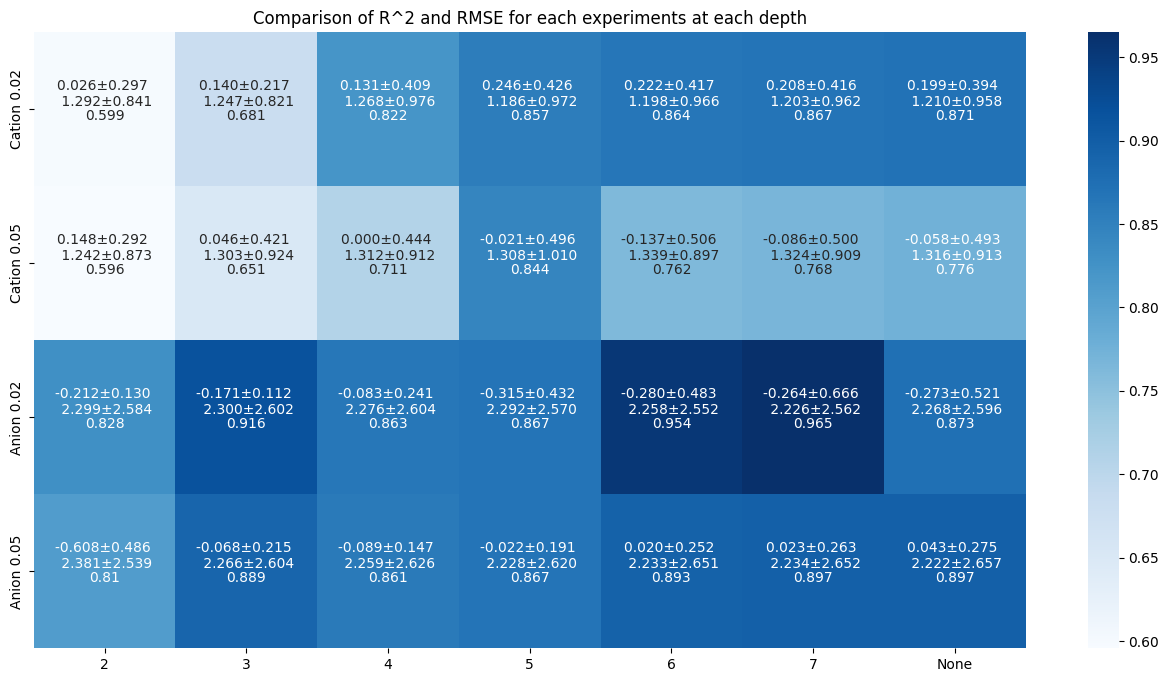

In [ ]:
val_df = pd.DataFrame(r2_results, index=['Cation 0.02', 'Cation 0.05', 'Anion 0.02', 'Anion 0.05'], columns=[2, 3, 4, 5, 6, 7, "None"])
plt.figure(figsize = (16,8))
plt.title("Comparison of R^2 and RMSE for each experiments at each depth")
sn.heatmap(val_df, annot=False, cmap='Blues')
sn.heatmap(val_df, annot=mean_std_results, annot_kws={'va':'bottom'}, cbar=False, fmt='', cmap='Blues')
sn.heatmap(val_df, annot=r2_results, annot_kws={'va':'top'}, fmt='.3g', cbar=False, cmap='Blues')
plt.savefig("./exp_results_heatmaps_14_membranes.jpg")


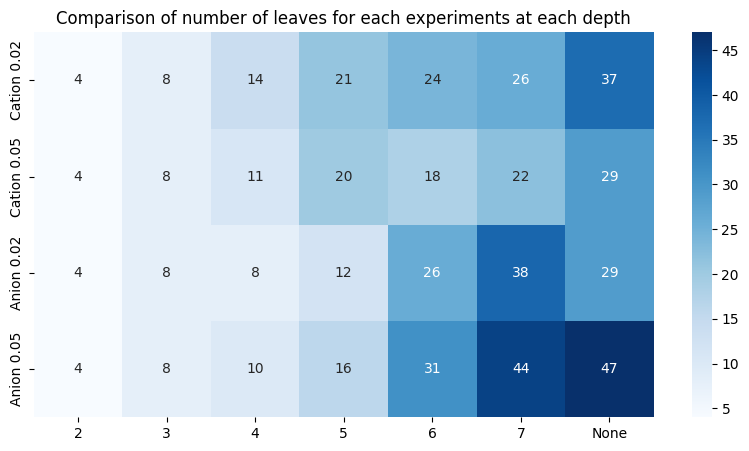

In [ ]:
plt.figure(figsize = (10,5))
plt.title("Comparison of number of leaves for each experiments at each depth")
leaves_df = pd.DataFrame(leaves_results, index=['Cation 0.02', 'Cation 0.05', 'Anion 0.02', 'Anion 0.05'], columns=[2, 3, 4, 5, 6, 7, "None"])
sn.heatmap(leaves_df, annot=leaves_df, cmap='Blues')
plt.savefig("./depth_heatmaps_14_membranes.jpg")